In [1]:
import sys, os, argparse, numpy as np, logging, pandas as pd
from sklearn.externals import joblib
from copy import deepcopy
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

Create sample data.

In [2]:
from numpy.random import RandomState

def generate_noisy_subcliques(nodes_per_clique, inside_p, across_p, min_node_label=0, seed=None):
    """Generates a graph which consists of small cliques connected with each other.
    The noise within a clique and across cliques can be set by the `inside_p` and 
    `across_p` parameters respectively.   This is also called a "stochastic block model."
    
    
    Parameters
    ----------
    nodes_per_clique : list
        The size of this list corresponds to the number of cliques that will be
        generated. The value of each element will be the size of the corresponding 
        clique.
        
    inside_p : float
        The probability of an edge inside a clique. The higher this number, the more 
        each clique will resemble a fully connected graph.
        
    across_p : float
        The probability of an edge across cliques.
        
    min_node_label : int, default is 0
        The minimum node label of the graph.
        
    seed : int, default is None
        The seed to the pseudorandom number generator.
        
    
    Returns
    -------
    G : networkX graph
        The generated graph.
    """

    prng = RandomState(seed)
    clique_list = []
    number_of_cliques = len(nodes_per_clique)

    # Make the independent cliques
    starting_node = min_node_label
    for clique in range(number_of_cliques):
        G = nx.Graph()
        for u in range(starting_node, starting_node + nodes_per_clique[clique]):
            for v in range(u + 1, starting_node + nodes_per_clique[clique]):
                if prng.rand() < inside_p:
                    G.add_edge(u, v)
        clique_list.append(G)
        starting_node += nodes_per_clique[clique]

    # Combine them in one graph
    G = nx.Graph()
    for clique in range(number_of_cliques):
        G.add_edges_from(clique_list[clique].edges())

    # Connect edges across the cliques
    for i in range(number_of_cliques):
        clique_from = clique_list[i]
        for j in range(i + 1, number_of_cliques):
            clique_to = clique_list[j]
            for u in clique_from.nodes():
                for v in clique_to.nodes():
                    if prng.rand() < across_p:
                        G.add_edge(u, v)
    return G

def regularized_laplacian(L, lam):
    return np.linalg.inv(np.eye( *np.shape(L) ) + (lam * L))

def rkhs_factor(D):
    e, v = sp.linalg.eigh(D)
    return v.dot(np.diag(np.sqrt(e)))


Source network is large, target is small.  Different sized graphs are important to explore issues here.

In [3]:
across_p = 0.05
inside_p = 0.9
G = {}
np.random.seed(2)
G['S'] = generate_noisy_subcliques([10, 10, 10], inside_p, across_p, seed=2)
G['T'] = generate_noisy_subcliques([5, 5, 5], inside_p, across_p, seed=2)

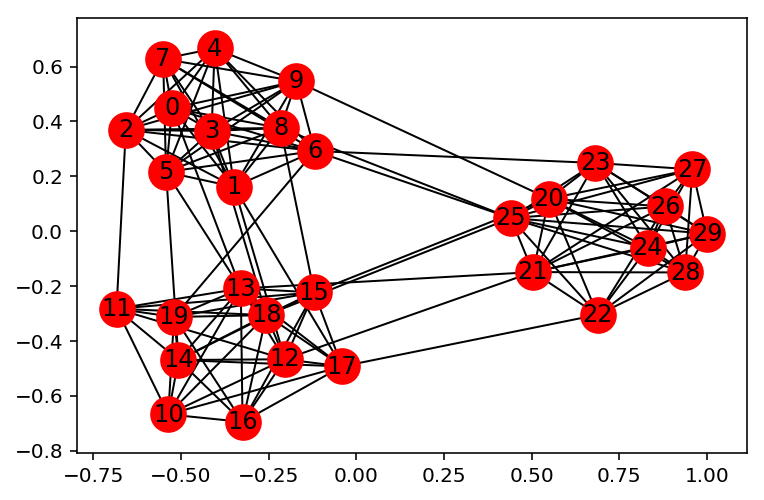

In [4]:
nx.draw_networkx(G['S'], with_labels=True)

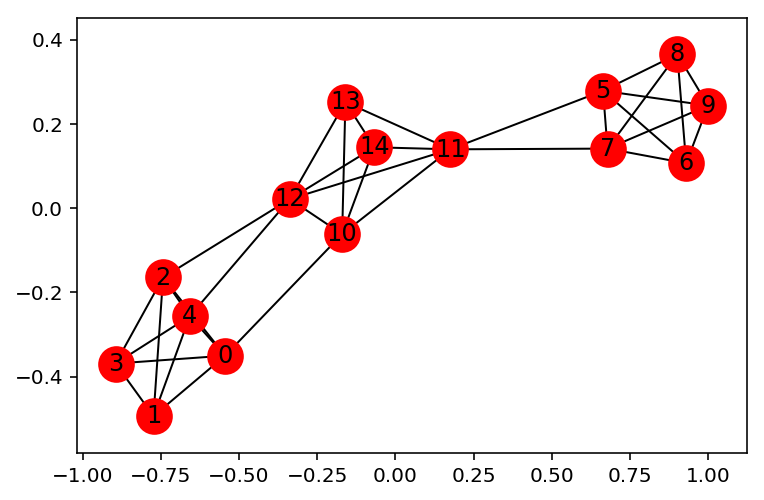

In [39]:
nx.draw_networkx(G['T'], with_labels=True)

We use three landmarks: one in each cluster.  (Within a cluster, all nodes are essentially equivalent, so we just choose one from each cluster.)

In [6]:
lands = {'S': [0, 10, 20], 'T': [0, 5, 10]}
N_S = np.sum(lands['S'])
N_T = np.sum(lands['T'])

Construct Diffusion Matrices

In [7]:
D = {}
C = {}
lam = 0.05
for species in ['S', 'T']:
    L = np.array(nx.laplacian_matrix(G[species]).todense())
    D[species] = regularized_laplacian(L, lam)
    C[species] = rkhs_factor(D[species])
                 
C1 = C['S']
C2 = C['T']
D1 = D['S']
D2 = D['T']
C1L = C1[lands['S']]
D2L = D2[lands['T']]

Perform HANDL.  We construct the embedding of the target species in the source vector space.  As described in the paper, this is done by treating the diffusion scores to landmarks in the target species ($D_{2L}$) as if they applied to the landmarks in the source species.  This implies the linear system
$$ D_{2L} = C_{1L} \hat{C_2}^T $$
which we solve via 
$$ \hat{C_2}^T = C_{1L}^\dagger D_{2L} $$
yielding the embedding for the nodes in the target network $\hat{C_2}^T$.

In [8]:
C2_hat_T = np.linalg.pinv(C1L).dot(D2L)
C2_hat = C2_hat_T.T

Finally we construct the HANDL homology scores by simply taking the inner products of the corresponding embedding vectors:
$$ D_{12} = C_1 \hat{C_2}^T.$$

In [9]:
D12 = C1.dot(C2_hat_T)

There are at least two undesirable effects: (a) landmarks are very close to each other and (b) (faintly visible) landmarks are closer to other nodes in general than non-landmarks are.

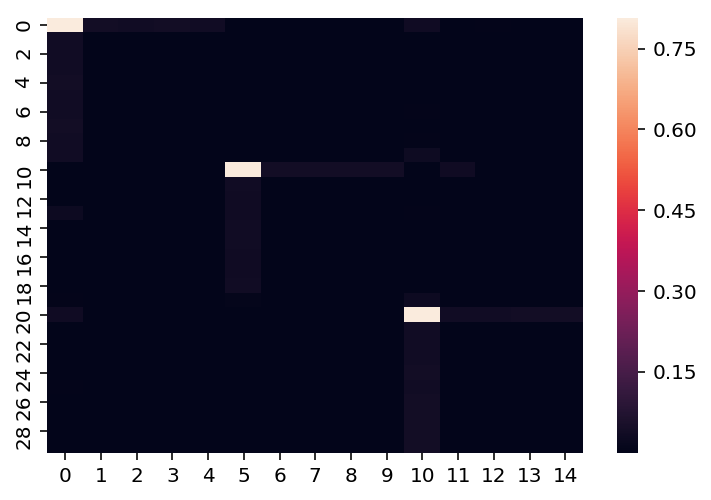

In [10]:
sns.heatmap(D12);

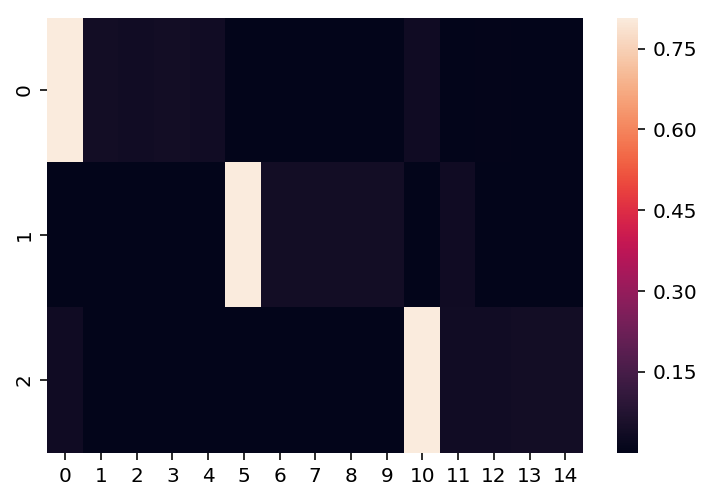

In [11]:
sns.heatmap(D12[lands['S']]);

However, the key benefit of HANDL is present.  Off the diagonal, $D_{12}$ nicely captures the mapping of nodes between source and destination.  It captures connectivity well, eg, placing connecting nodes intermediate between clusters.

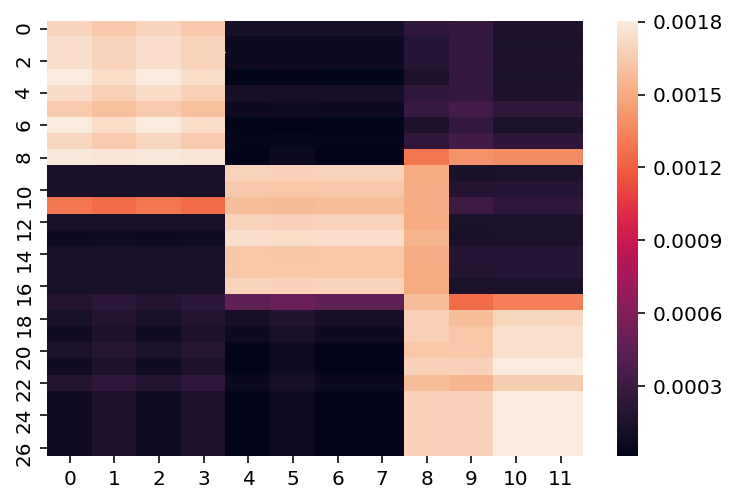

In [12]:
non_landmarks_S = [i for i in range(N_S) if i not in lands['S']]
non_landmarks_T = [i for i in range(N_T) if i not in lands['T']]
sns.heatmap(D12[non_landmarks_S][:, non_landmarks_T]);

## Using a linear classifier with HANDL

A standard linear classifier will not do well on transfer learning betwen $C_1$ and $\hat{C_2}$.   To show that, we train an SVM to classify cluster 1 (nodes 0-9) in the source network.

C value for this data: 1
SVM on training set: precision 1.0, recall 1.0, f1 1.0.


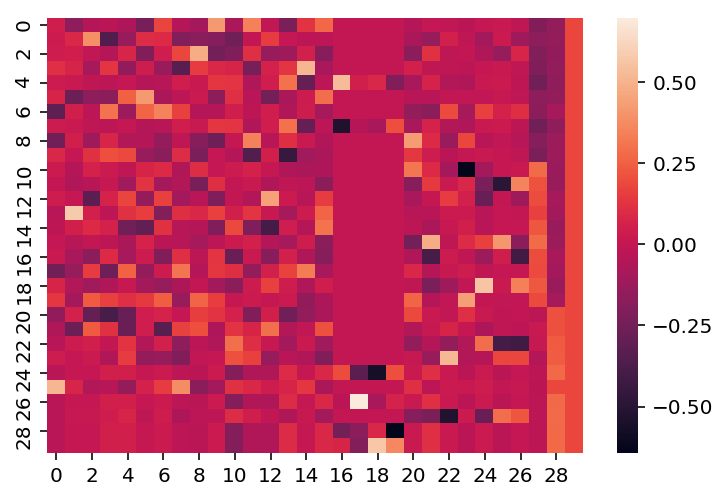

In [13]:
import sklearn.svm as svm
import sklearn
labels_S = 10 * [1] + 20 * [0]
labels_T = 5 * [1] + 10 * [0]

def train_svm(X, y):
    Cvals = [0.01, 0.1, 1, 10, 100, 1000, 10000]
    metrics = []
    clfs = []
    for C in Cvals:
        svc = svm.SVC(kernel='linear', C = C)
        svc.fit(X, y)
        pred = svc.predict(X)
        if 1 in pred:
            metrics.append(sklearn.metrics.f1_score(y, pred))
        else:
            metrics.append(0)
        clfs.append(svc)
    best = np.where(metrics == max(metrics))
    return clfs[best[0][0]]


svc = train_svm(C1, labels_S)
print('C value for this data: {}'.format(svc.C))
svc.fit(C1, labels_S)
pred_S = svc.predict(C1)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels_S, pred_S)
print("SVM on training set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))
sns.heatmap(C1);

However, the source-trained SVM does poorly at this task when applied to the target network.  Here, we are looking for the corresponding cluster 1 in the target, which are nodes 0-4.

In [14]:
pred_T = svc.predict(C2_hat)
print(pred_T)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels_T, pred_T)
print("SVM on test set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
SVM on test set: precision 1.0, recall 0.2, f1 0.33333333333333337.


Nonetheless, the SVM _can_ do well if trained on the original target vectors directly:

In [15]:
svc = train_svm(C2, labels_T)
print('C value for this data: {}'.format(svc.C))
svc.fit(C2, labels_T)
pred_T = svc.predict(C2)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels_T, pred_T)
print("SVM trained and tested on C2 set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))

C value for this data: 1
SVM trained and tested on C2 set: precision 1.0, recall 1.0, f1 1.0.


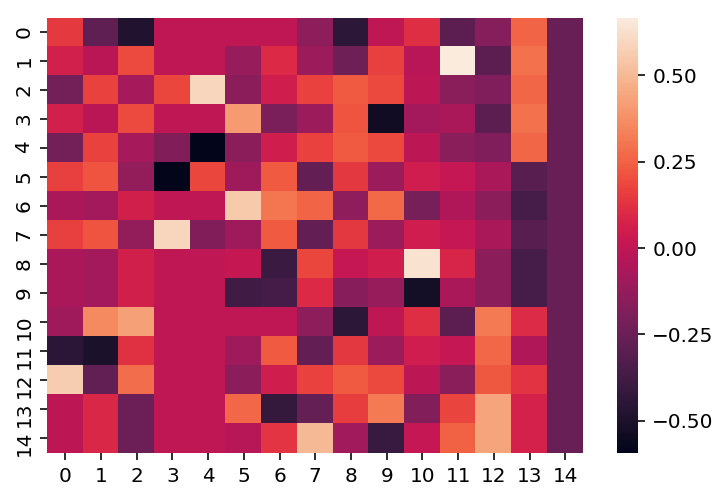

In [16]:
sns.heatmap(C2);

As well as when it is trained on the inferred target vectors:

In [17]:
svc = train_svm(C2_hat, labels_T)
print('C value for this data: {}'.format(svc.C))
svc.fit(C2_hat, labels_T)
pred_T = svc.predict(C2_hat)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels_T, pred_T)
print("SVM trained and tested on C2_hat set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))

C value for this data: 100
SVM trained and tested on C2_hat set: precision 1.0, recall 1.0, f1 1.0.


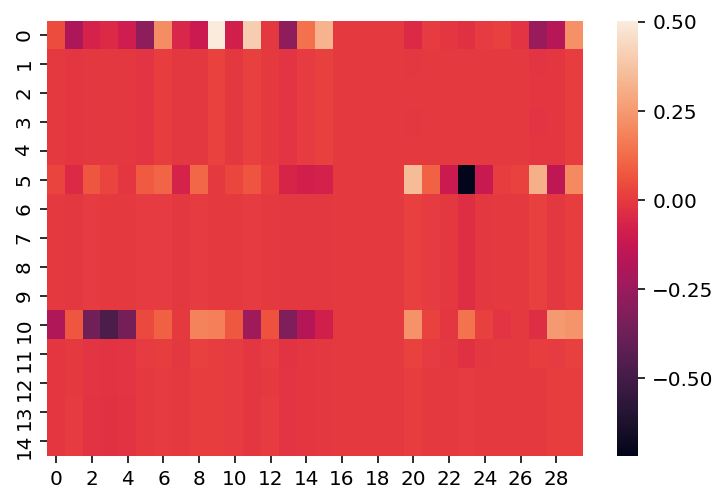

In [18]:
sns.heatmap(C2_hat);

Note also that if we artifically remove the effect of the large-normed landmarks, the distinctions between the classes become very clear:

C value for this data: 100
SVM trained and tested on C2_explore set: precision 1.0, recall 1.0, f1 1.0.


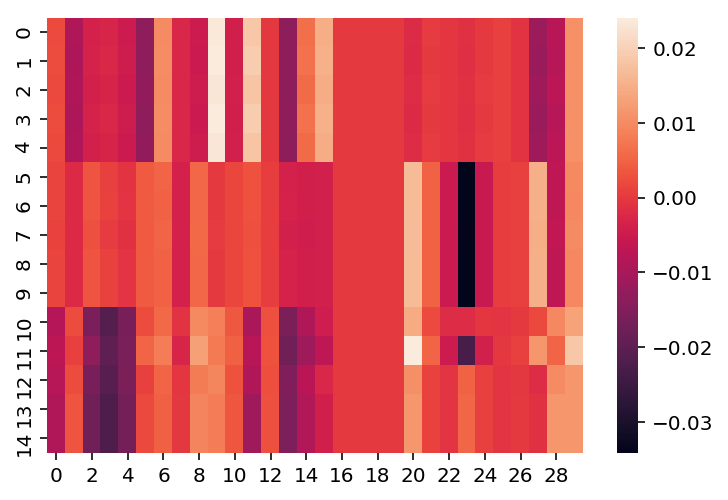

In [19]:
C2_explore = C2_hat.copy()
C2_explore[0] = np.mean(C2_explore[1:5], axis=0)
C2_explore[5] = np.mean(C2_explore[6:10], axis=0)
C2_explore[10] = np.mean(C2_explore[11:16], axis=0)
sns.heatmap(C2_explore)
svc = train_svm(C2_explore, labels_T)
print('C value for this data: {}'.format(svc.C))
svc.fit(C2_explore, labels_T)
pred_T = svc.predict(C2_explore)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels_T, pred_T)
print("SVM trained and tested on C2_explore set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))

On inspection the distributions of the target and source vectors are completely different.

In [20]:
def centering_matrix(n):
    return np.eye(n) - 1/float(n) * np.ones((n,n))

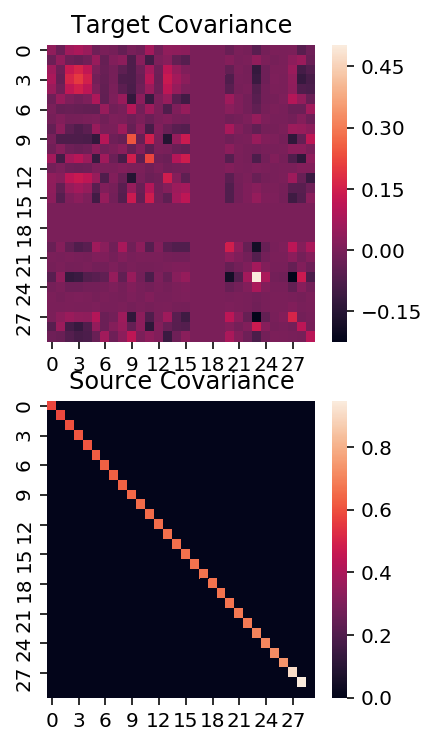

In [35]:
J_S = centering_matrix(D1.shape[0])
J_T = centering_matrix(D2.shape[0])

C1_centered = J_S @ C1
C2_centered = J_T @ C2_hat

C1_cov = C1_centered.T @ C1_centered
C2_cov = C2_centered.T @ C2_centered

plt.figure(figsize=(3,6))
plt.subplot(2,1,1)
sns.heatmap(C2_cov)
plt.title('Target Covariance')
plt.subplot(2,1,2)
sns.heatmap(C1_cov)
plt.title('Source Covariance');

Norms of the $C_1$ and $\hat{C_2}$ vectors are totally different.

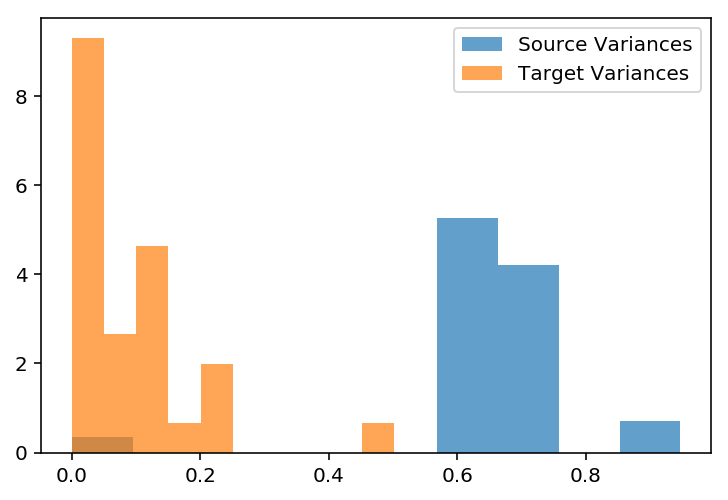

In [22]:
plt.hist(np.diag(C1_cov), density=True, label='Source Variances', alpha=0.7)
plt.hist(np.diag(C2_cov), density=True, label='Target Variances', alpha=0.7)
plt.legend(loc='best');

The off-diagonal elements of the cross-covariance matrix are very small for the source, while they are much larger for the target.  This agrees with what we see in practice in real data (when inspecting the Sc and Sp sum features).

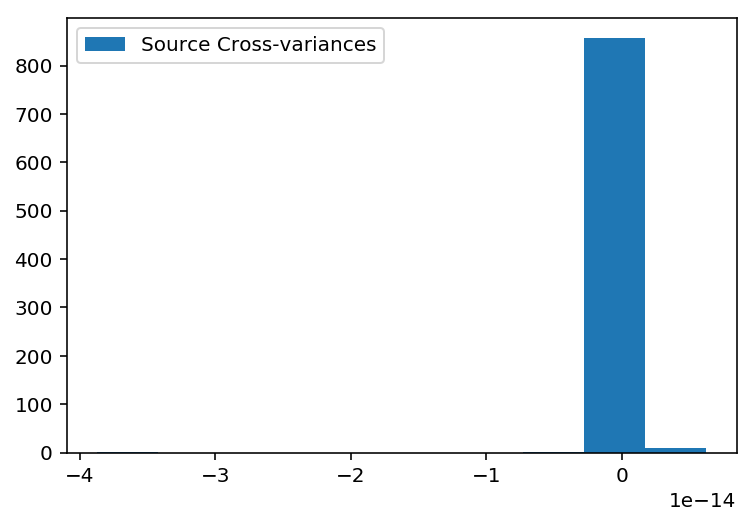

In [23]:
plt.hist(np.extract(1 - np.eye(N_S), C1_cov), label='Source Cross-variances')
plt.legend(loc='best');

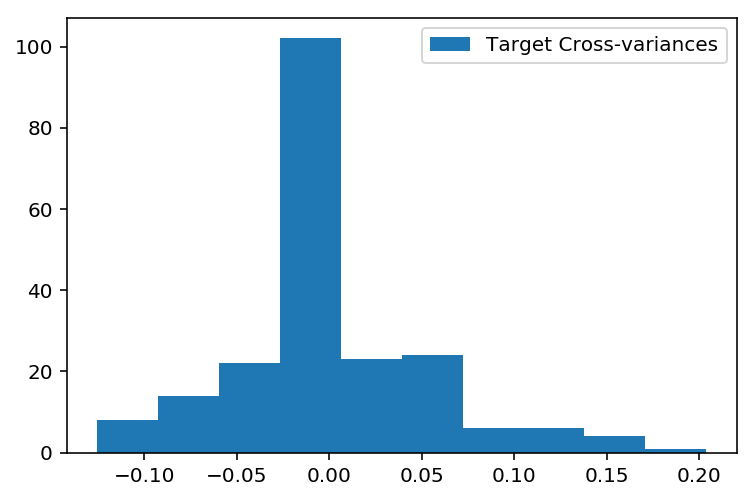

In [24]:
plt.hist(np.extract(1 - np.eye(N_T), C2_cov),label='Target Cross-variances')
plt.legend(loc='best');

## Adjusting variances and covariances using CORAL
 
Now we bring the two sets of covariances into agreement using CORAL.   
 
NB: in general, the square root of a PD matrix is not unique.  However, there is only one PD square root of a PD matrix.  This "the" square root and what numpy or MATLAB computes.  Essentially, we are looking for a transformation that shrinks or stretches in each direction without doing any "flips".  This makes sense if the source and target domains are similar to some degree -- no feature in either 

In [25]:
# regularize
lamb = 0.00001
CS = C1_cov + lamb * np.eye(*C1_cov.shape)
CT = C2_cov + lamb * np.eye(*C2_cov.shape)

source_to_target = True
if source_to_target:
    # this is the recommended approach in the coral paper
    CS_sqrt = np.real_if_close(sp.linalg.sqrtm(CS))
    DS = C1_centered @ np.linalg.pinv(CS_sqrt)
    NC_S = DS @ np.real_if_close(sp.linalg.sqrtm(CT))
else:
    # contrary to the coral paper we are 'fitting' the target distribution
    # into the source's distributional shape
    CT_sqrt = np.real_if_close(sp.linalg.sqrtm(CT))
    DT = C2_centered @ np.linalg.inv(CT_sqrt)
    NC_T = DT @ np.real_if_close(sp.linalg.sqrtm(CS))

Verifying CORAL's effects

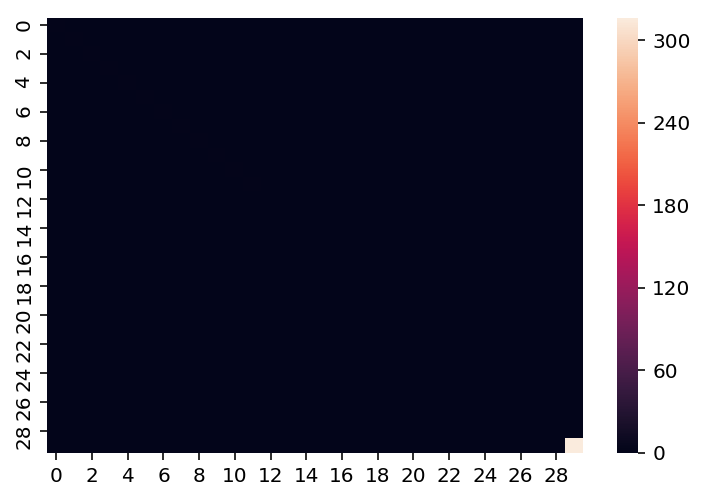

In [26]:
sns.heatmap(np.linalg.pinv(CS_sqrt));

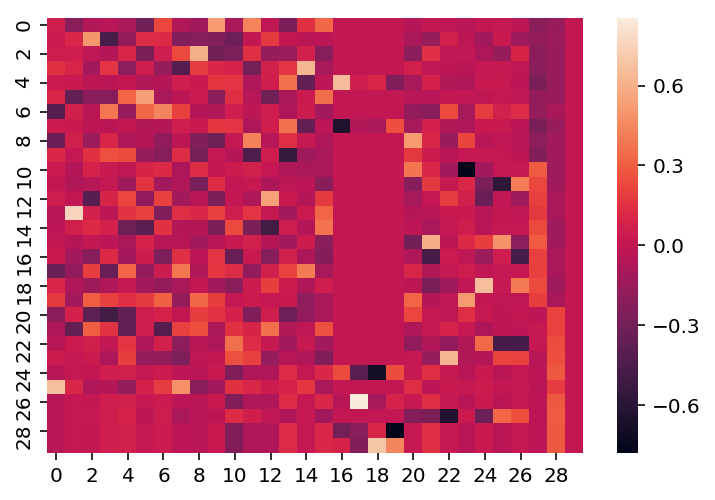

In [27]:
sns.heatmap(DS);

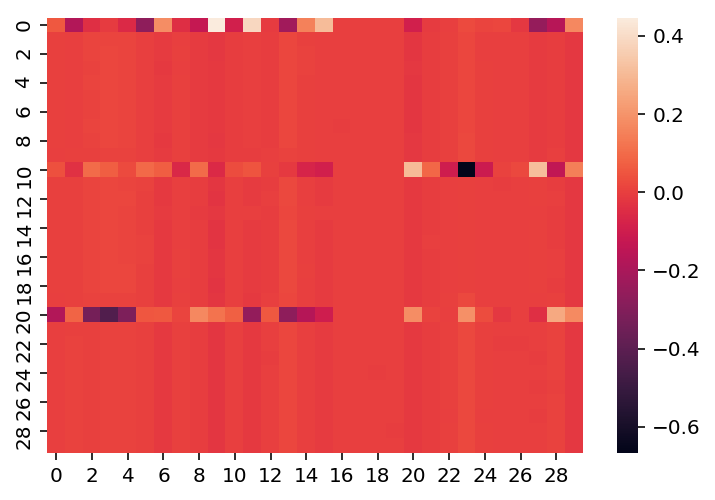

In [28]:
sns.heatmap(NC_S);

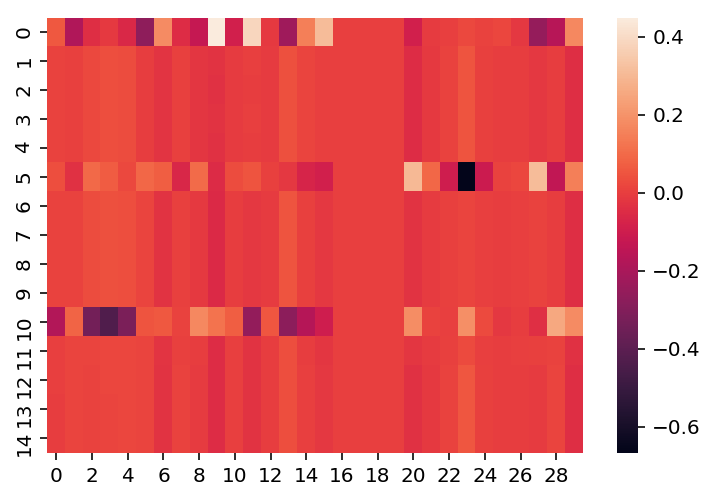

In [29]:
sns.heatmap(C2_centered);

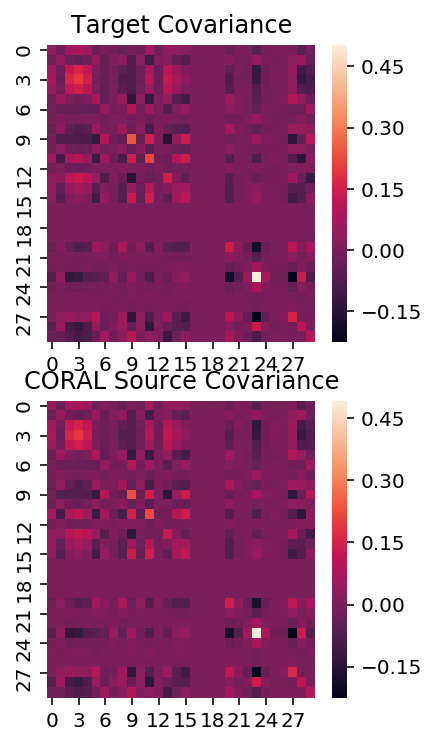

In [30]:
C1_Centered_CORAL = J_S @ NC_S
C1_cov_CORAL = C1_Centered_CORAL.T @ C1_Centered_CORAL
plt.figure(figsize=(3,6))
plt.subplot(2,1,1)
sns.heatmap(C2_cov)
plt.title('Target Covariance')
plt.subplot(2,1,2)
sns.heatmap(C1_cov_CORAL)
plt.title('CORAL Source Covariance');

In [31]:
svc = train_svm(C1_Centered_CORAL, labels_S)
print('C value for this data: {}'.format(svc.C))
svc.fit(C1_Centered_CORAL, labels_S)
pred_S = svc.predict(C1_Centered_CORAL)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels_S, pred_S)
print("SVM on CORALIZED source set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))
#
pred_T = svc.predict(C2_centered)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels_T, pred_T)
print("SVM on target set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))

C value for this data: 10000
SVM on CORALIZED source set: precision 1.0, recall 1.0, f1 1.0.
SVM on target set: precision 1.0, recall 1.0, f1 1.0.


In [37]:
svc = train_svm(C2_centered, labels_T)
print('C value for this data: {}'.format(svc.C))
svc.fit(C2_centered, labels_T)
pred_T = svc.predict(C2_centered)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels_T, pred_T)
print("SVM on Centered test (trained on) set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))
svc.fit(C2_hat, labels_T)
pred_T = svc.predict(C2_hat)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels_T, pred_T)
print("SVM on C2 test (trained on) set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))

C value for this data: 100
SVM on Centered test (trained on) set: precision 1.0, recall 1.0, f1 1.0.
SVM on C2 test (trained on) set: precision 1.0, recall 1.0, f1 1.0.


## Possible Other Approaches

Hence we want to find solutions that maintain the HANDL criterion (least-squares fit) while attempting to get close to the covariance distribution.

We work with the full HANDL solution set.
$$ \hat{C_2}^T = C_{1L}^\dagger D_{2L} + (I - C_{1L}^\dagger C_{1L}) W $$
The two terms correspond to contributions from the row space of $C_{1L}$ and the nullspace of $C_{1L}$.  The idea is to add some component from the null space to more closely match the covariance of the source.  We do this by finding the appropriate $W$.